### Install Things

In [1]:
!pip install transformers
!pip install timm

### Import Things

In [2]:
import pandas as pd
import numpy as np
import torch
import math
#import timm
from PIL import Image, ImageDraw, ImageFont
from transformers import AutoModelForObjectDetection, AutoImageProcessor

/Users/acer1/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Functions

In [3]:
# Get center of bounding box
def get_center(x_min, y_min, x_max, y_max):
    mid_x = (x_min + x_max) / 2
    mid_y = (y_min + y_max) / 2
    
    return mid_x, mid_y

### Get Images

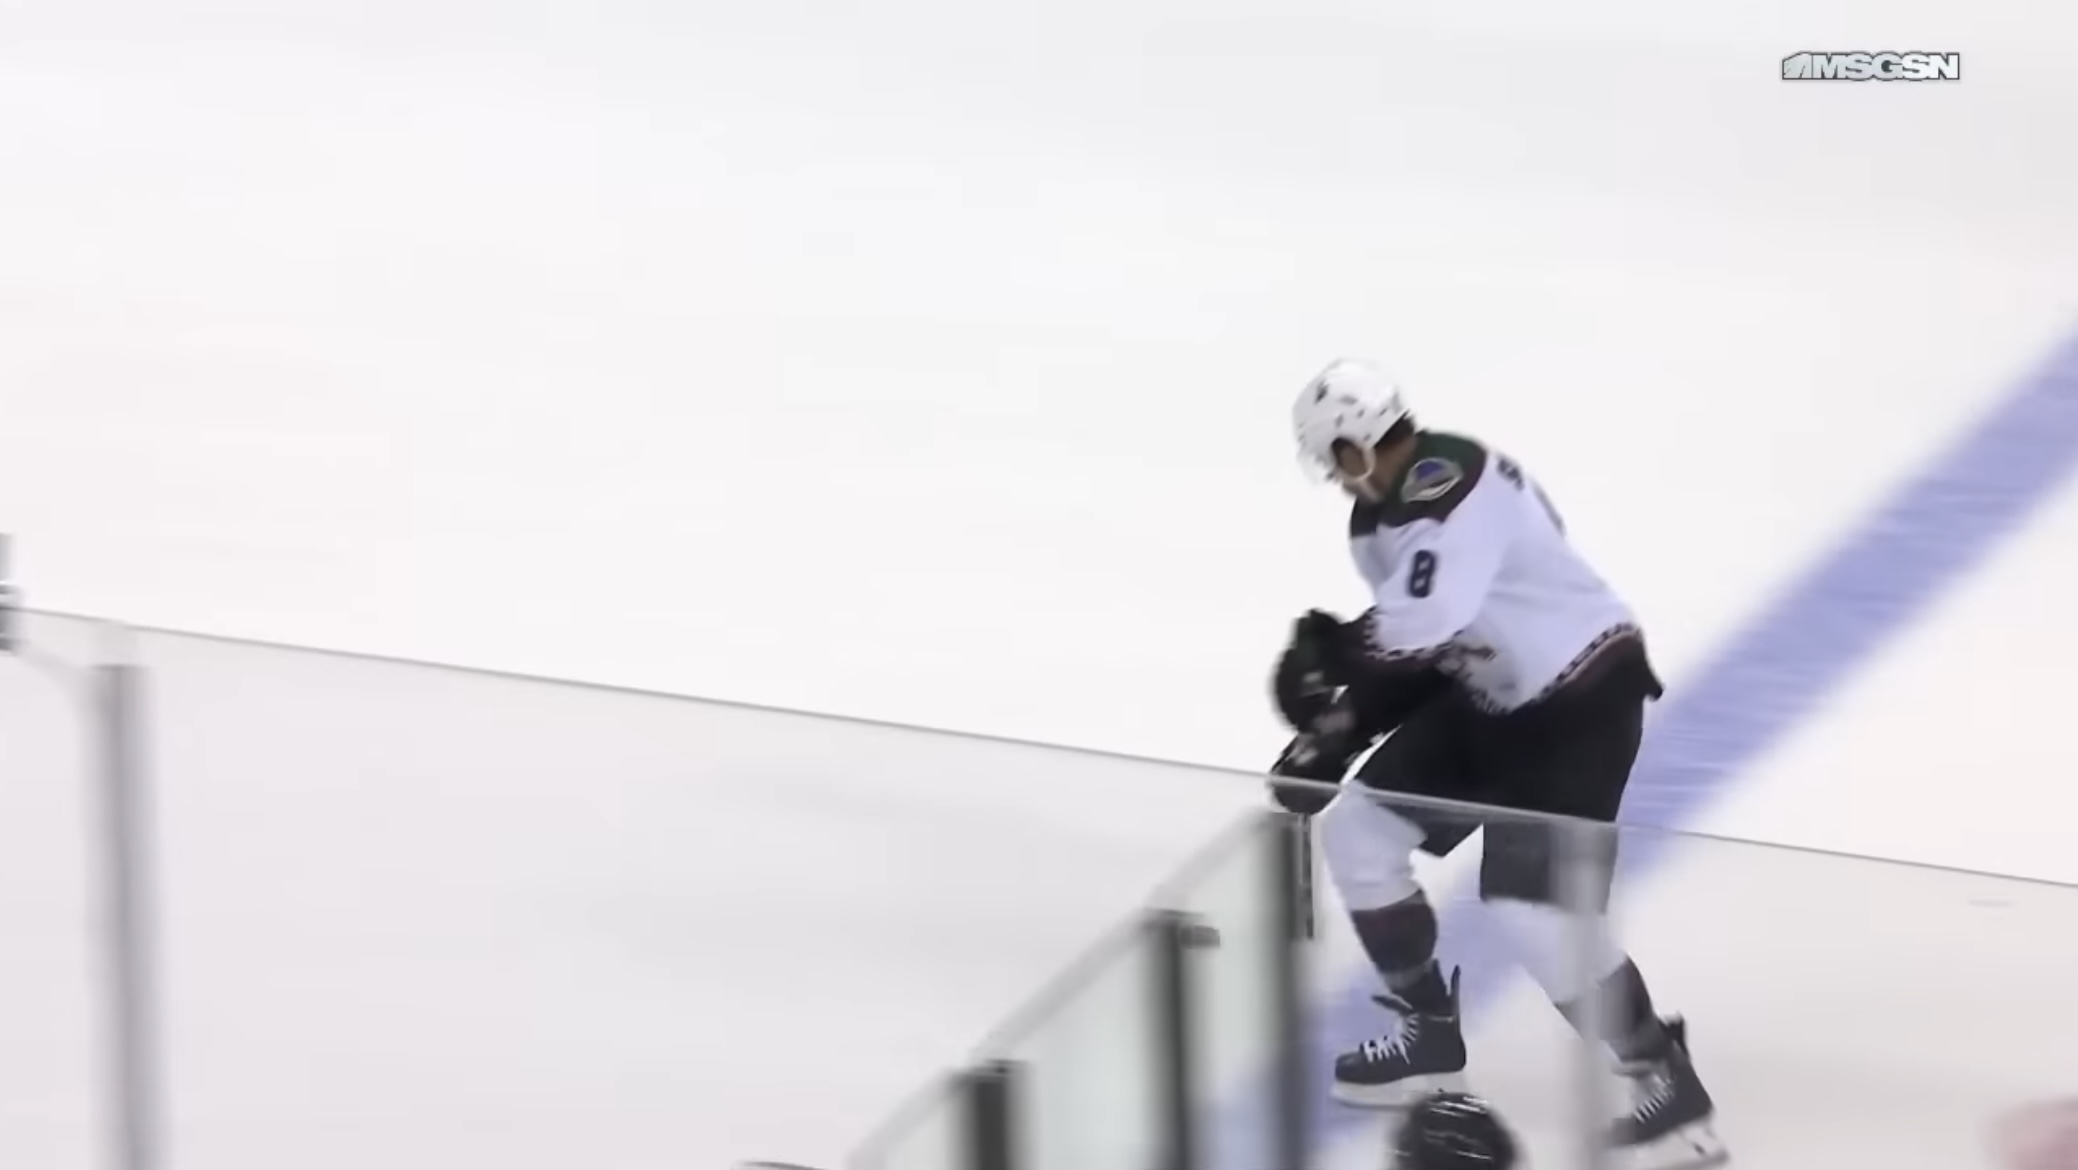

In [4]:
im1_path = "IMG_1967.jpg" 
im2_path = "IMG_1968.jpg"
im3_path = "IMG_1969.jpg"
im4_path = "IMG_1970.jpg"
im5_path = "IMG_1971.jpg"

im1 = Image.open(im1_path).convert("RGB")
im2 = Image.open(im2_path).convert("RGB")
im3 = Image.open(im3_path).convert("RGB")
im4 = Image.open(im4_path).convert("RGB")
im5 = Image.open(im5_path).convert("RGB")
ims = [im1, im2, im3, im4, im5]
im1

In [10]:
# Load a pre-trained DETR model (e.g., 'facebook/detr-resnet-50')
model_name = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForObjectDetection.from_pretrained(model_name)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/Users/acer1/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:2068: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/Users/acer1/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:2068: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current 

In [29]:
for im in ims:
    # Process the image for the model
    inputs = image_processor(images = im, return_tensors = "pt")

    with torch.no_grad():
        outputs = model(**inputs)

    # Post-process the outputs to get bounding boxes and labels
    target_sizes = torch.tensor([im.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold = 0.9, target_sizes = target_sizes)[0]

    # Bounding box format [x_min, y_min, x_max, y_max]
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        print(f"Detected {model.config.id2label[label.item()]} with score {round(score.item(), 3)} at {box.tolist()}")

Detected person with score 0.999 at [1262.28173828125, 356.5804443359375, 1722.556640625, 1155.1517333984375]
Detected person with score 0.994 at [75.56038665771484, 1060.338623046875, 266.2953796386719, 1169.8021240234375]
Detected person with score 0.998 at [1145.9278564453125, 395.12054443359375, 1593.1187744140625, 1155.6873779296875]
Detected person with score 0.968 at [134.272216796875, 1116.787841796875, 219.04873657226562, 1169.9482421875]
Detected person with score 0.988 at [321.1683044433594, 1089.07421875, 427.6871032714844, 1169.8658447265625]
Detected person with score 1.0 at [1088.608154296875, 337.32635498046875, 1618.6514892578125, 1154.7222900390625]
Detected person with score 0.995 at [912.0427856445312, 1058.0833740234375, 1099.4169921875, 1169.7183837890625]
Detected person with score 0.995 at [238.63685607910156, 1091.4781494140625, 412.0140380859375, 1170.05126953125]
Detected skis with score 0.96 at [1102.6676025390625, 1076.631103515625, 1420.771728515625, 1166.

In [6]:
# Process the image for the model
inputs = image_processor(images = im1, return_tensors = "pt")

In [7]:
with torch.no_grad():
    outputs = model(**inputs)

# Post-process the outputs to get bounding boxes and labels
target_sizes = torch.tensor([im1.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]

# bounding box format [x_min, y_min, x_max, y_max]
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    print(f"Detected {model.config.id2label[label.item()]} with score {round(score.item(), 3)} at {box.tolist()}")

Detected person with score 0.999 at [1262.28173828125, 356.5804443359375, 1722.556640625, 1155.1517333984375]


{'person': 1}


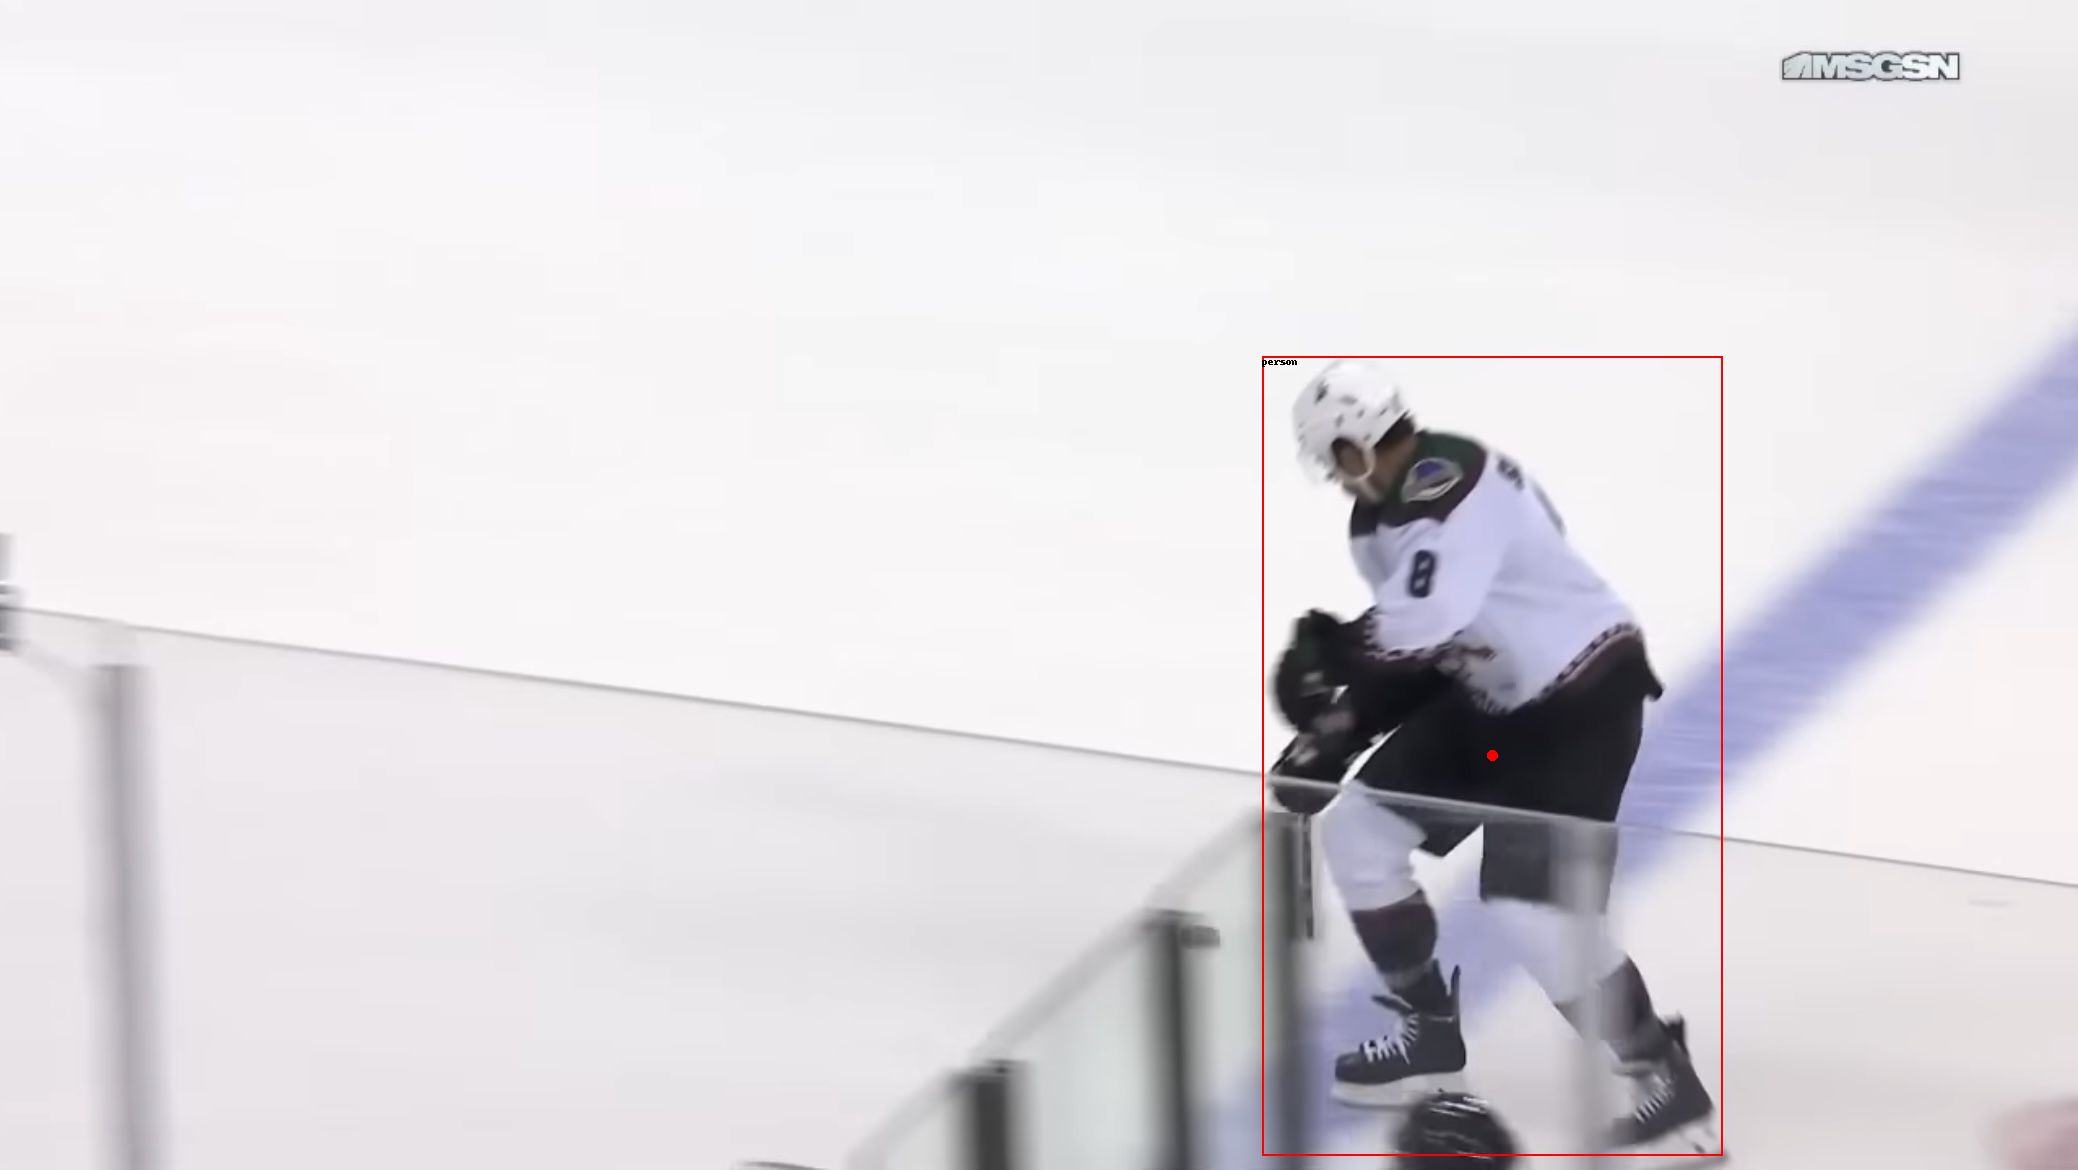

In [8]:
out_im1 = im1.copy()
draw = ImageDraw.Draw(out_im1)
summary = {}
r = 5

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    lbl = model.config.id2label[label.item()]
    x, y, x2, y2 = tuple(box)
    center = get_center(box[0], box[1], box[2], box[3])
    draw.rectangle((x, y, x2, y2), outline = "red", width = 2)
    draw.text((x, y), lbl, fill = "black")
    draw.ellipse((center[0]-r, center[1]-r, center[0]+r, center[1]+r), fill="red")
    count = summary.get(lbl, 0)
    count += 1
    summary[lbl] = count

print(summary)
out_im1

### Initialize Particles

In [9]:
particles = 10
center_x, center_y = center[0], center[1]
init_particle_x = np.random.normal(center_x, 100, particles)
init_particle_y = np.random.normal(center_y, 100, particles)
init_particle_x_velo = np.random.normal(0, 16, particles)
init_particle_y_velo = np.random.normal(0, 16, particles)

In [10]:
init_particle_x_velo

array([-5.90688869e+00,  3.98546494e+01, -2.36483428e-02, -5.02948680e+00,
        6.52946670e+00, -8.49137211e+00, -9.15720073e+00,  1.07432778e+01,
       -1.20843931e+01, -3.01079517e+01])

### Predict Next Time Step

In [11]:
particle_x_noise = np.random.normal(0, 4, particles)
particle_y_noise = np.random.normal(0, 4, particles)
particle_x_velo_noise = np.random.normal(0, 4, particles)
particle_y_velo_noise = np.random.normal(0, 4, particles)

In [12]:
x_next = init_particle_x + init_particle_x_velo + particle_x_noise
y_next = init_particle_y + init_particle_y_velo + particle_y_noise
x_velo_next = init_particle_x_velo + particle_x_velo_noise
y_velo_next = init_particle_y_velo + particle_y_velo_noise

### Get Distances From Next Time Step Location

In [13]:
# Process the image for the model
inputs = image_processor(images = im2, return_tensors = "pt")

In [14]:
with torch.no_grad():
    outputs = model(**inputs)

# Post-process the outputs to get bounding boxes and labels
target_sizes = torch.tensor([im1.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]

# bounding box format [x_min, y_min, x_max, y_max]
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    print(f"Detected {model.config.id2label[label.item()]} with score {round(score.item(), 3)} at {box.tolist()}")

Detected person with score 0.994 at [75.74263000488281, 1060.338623046875, 266.9376525878906, 1169.8021240234375]
Detected person with score 0.998 at [1148.6917724609375, 395.12054443359375, 1596.9613037109375, 1155.6873779296875]


{'person': 2}


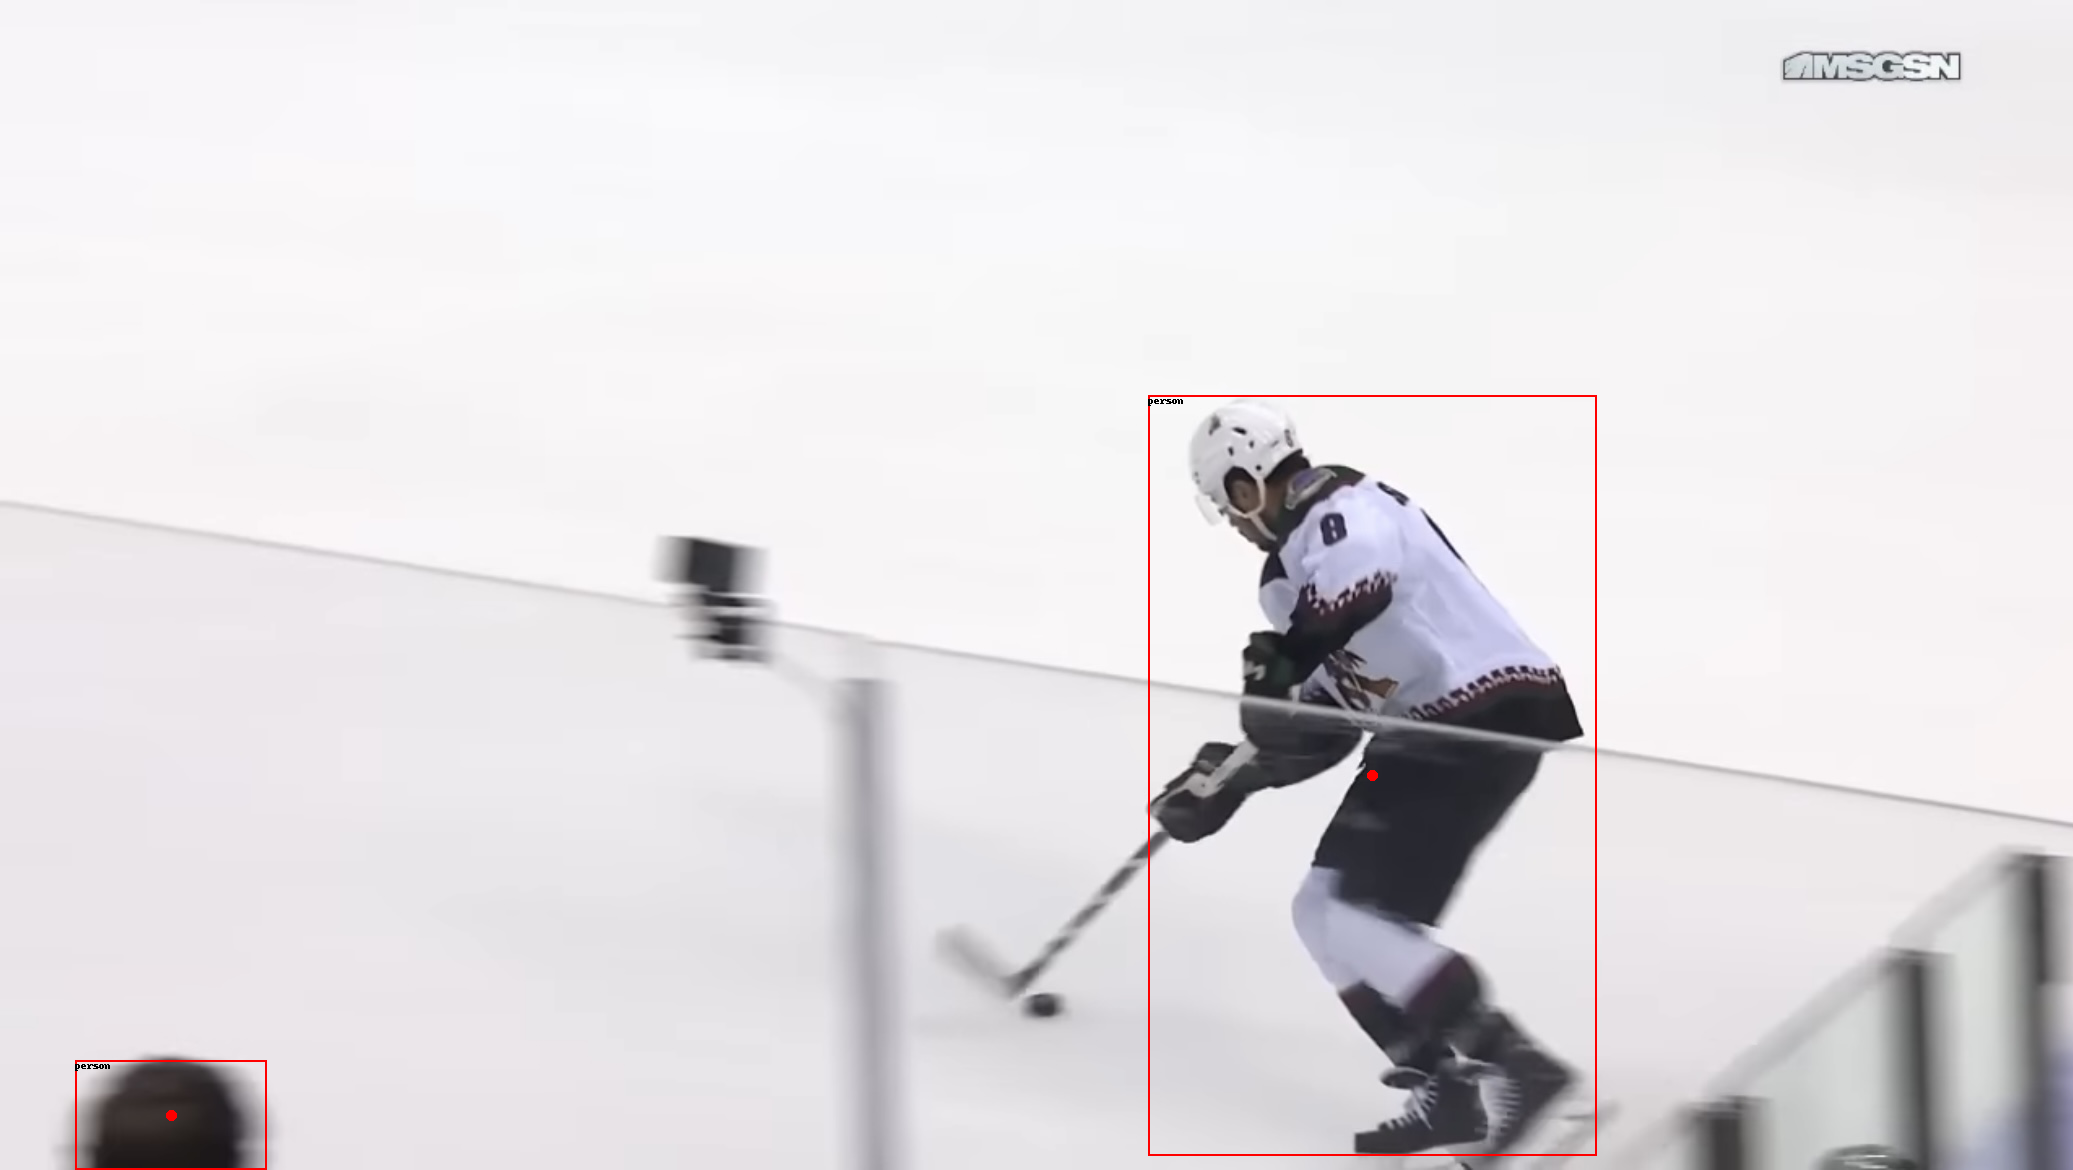

In [15]:
out_im2 = im2.copy()
draw = ImageDraw.Draw(out_im2)
summary = {}
r = 5

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    lbl = model.config.id2label[label.item()]
    x, y, x2, y2 = tuple(box)
    center = get_center(box[0], box[1], box[2], box[3])
    draw.rectangle((x, y, x2, y2), outline = "red", width = 2)
    draw.text((x, y), lbl, fill = "black")
    draw.ellipse((center[0]-r, center[1]-r, center[0]+r, center[1]+r), fill="red")
    count = summary.get(lbl, 0)
    count += 1
    summary[lbl] = count

print(summary)
out_im2

In [16]:
next_loc = get_center(results["boxes"][1][0], results["boxes"][1][1], results["boxes"][1][2], results["boxes"][1][3])
next_loc_x, next_loc_y = next_loc[0], next_loc[1]

In [17]:
particle_dist = np.sqrt(([next_loc_x.item()] * particles - x_next) ** 2 + ([next_loc_y.item()] * particles - y_next) ** 2)
particle_dist

array([ 85.9894586 , 250.12679725, 268.09291717, 131.81729246,
       247.33416888, 221.37239471, 121.41868992, 136.58611524,
        25.63879793, 211.94405982])

In [18]:
particle_weights = 1/particle_dist
particle_weights

array([0.01162933, 0.00399797, 0.00373005, 0.00758626, 0.00404311,
       0.00451728, 0.00823596, 0.00732139, 0.03900339, 0.00471823])

In [19]:
sig = 1
weights = np.exp(-particle_dist/(2 * sig ** 2))
weights

array([2.12630869e-19, 4.84904361e-55, 6.08643121e-59, 2.37814665e-29,
       1.95914976e-54, 8.50345204e-49, 4.30790864e-27, 2.19130043e-30,
       2.70773257e-06, 9.48270354e-47])

In [20]:
# Normalize Weights
norm_weights = weights / sum(weights)
print(norm_weights)
sum(norm_weights)

[7.85272783e-14 1.79081334e-49 2.24779628e-53 8.78279738e-24
 7.23538867e-49 3.14043275e-43 1.59096533e-21 8.09275058e-25
 1.00000000e+00 3.50208276e-41]


1.0

In [21]:
# Sample particles
sampled_particles = np.random.choice(list(range(particles)), p = norm_weights, size = particles)
sampled_particles

array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8])

In [24]:
# Initialize new sampled particles
new_x_next = x_next[sampled_particles]
new_y_next = y_next[sampled_particles]
new_x_velo_next = x_velo_next[sampled_particles]
new_y_velo_next = y_velo_next[sampled_particles]

In [25]:
# Predict next time step
new_particle_x_noise = np.random.normal(0, 4, particles)
new_particle_y_noise = np.random.normal(0, 4, particles)
new_particle_x_velo_noise = np.random.normal(0, 4, particles)
new_particle_y_velo_noise = np.random.normal(0, 4, particles)

new_x_next = new_x_next + new_x_velo_next + new_particle_x_noise
new_y_next = new_y_next + new_y_velo_next + new_particle_y_noise
new_x_velo_next = new_x_velo_next + new_particle_x_velo_noise
new_y_velo_next = new_y_velo_next + new_particle_y_velo_noise